In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os, sys
from glob import glob
import mdtraj as md

/home/gmh4/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gmh4/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/gmh4/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gmh4/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
subarna_id_folder = "pdb_files_from_clusters/"
cluster_dict = {i:[] for i in range(5)}
subarna_pdb_cluster_trjs = {}
for folder in os.listdir(subarna_id_folder):

    if folder.find("files_5clusters_new_obj") != -1:
        cluster_id = int(folder.split("_")[0].replace('c', ''))
        subarna_pdb_cluster_trjs[cluster_id] = md.load(glob(os.path.join(subarna_id_folder, folder,"*.pdb")))

In [3]:
# search the directory and subdirectories of compare_pdb_structs/old_collection/ for all pdb files and put them in a list
ref_pdb_files = []
for root, dirs, files in os.walk("reference_actin_pdbs_cleaned/"):
    for file in files:
        if file.endswith(".pdb"):
             ref_pdb_files.append(os.path.join(root, file))



In [4]:
rmsd_dict = {}

for cluster_id,wrapped_trj in subarna_pdb_cluster_trjs.items():
    wrapped_atom_indices = wrapped_trj.top.select("(name CA) and (resSeq 7 to 38 or resSeq 53 to 365)")
    for pdb_file in ref_pdb_files:
        print("Processing",pdb_file)
        ref_trj = md.load(pdb_file)
        ref_atom_indices = ref_trj.top.select("(name CA) and (resSeq 7 to 38 or resSeq  53 to 365)")
        label = "-".join(pdb_file.split("/")[-2:]).replace(".pdb", "")
        try:
            wrapped_trj.superpose(ref_trj, atom_indices=wrapped_atom_indices, ref_atom_indices=ref_atom_indices)
            rmsd = md.rmsd(wrapped_trj, ref_trj, atom_indices=wrapped_atom_indices, ref_atom_indices=ref_atom_indices)
            rmsd_dict[(cluster_id,label)] = rmsd
        except ValueError:
            print("Could not calculate rmsd for {}".format(pdb_file))
            print(len(wrapped_atom_indices), len(ref_atom_indices))
            continue

Processing reference_actin_pdbs_cleaned/Flat/3J8I_chain.pdb
Processing reference_actin_pdbs_cleaned/Flat/2ZWH_chain.pdb


/home/gmh4/.local/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


Processing reference_actin_pdbs_cleaned/Flat/3MFP_chain.pdb
Processing reference_actin_pdbs_cleaned/Flat/3G37_chain.pdb
Processing reference_actin_pdbs_cleaned/Complexed/2A3Z_chain.pdb
Processing reference_actin_pdbs_cleaned/Complexed/2A40_chain.pdb
Processing reference_actin_pdbs_cleaned/Complexed/1HLU_profilin_chain.pdb
Processing reference_actin_pdbs_cleaned/Complexed/3UB5_profilin2_chain.pdb
Processing reference_actin_pdbs_cleaned/Twisted/1NWK_chain.pdb
Processing reference_actin_pdbs_cleaned/Twisted/1J6Z_chain.pdb
Processing reference_actin_pdbs_cleaned/Tilted/3J8J_chain.pdb
Processing reference_actin_pdbs_cleaned/Tilted/3J8K_chain.pdb
Processing reference_actin_pdbs_cleaned/Flat/3J8I_chain.pdb
Processing reference_actin_pdbs_cleaned/Flat/2ZWH_chain.pdb
Processing reference_actin_pdbs_cleaned/Flat/3MFP_chain.pdb
Processing reference_actin_pdbs_cleaned/Flat/3G37_chain.pdb
Processing reference_actin_pdbs_cleaned/Complexed/2A3Z_chain.pdb
Processing reference_actin_pdbs_cleaned/Comple

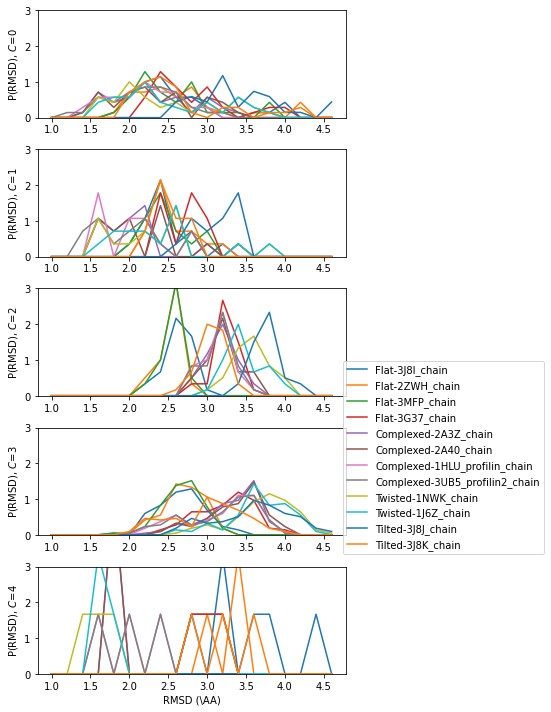

In [5]:
bins = np.arange(1,5,0.2)
# make 5 subplots
fig, ax = plt.subplots(5,1, figsize=(5,10))

all_rmsd_dicts = [{} for i in range(5)]

for cluster_id,label in rmsd_dict.keys():
    rmsd = rmsd_dict[(cluster_id,label)]
    if cluster_id==0: 
        my_label = label
    else:
        my_label = None
    category = label.split("-")[0]
    if category not in all_rmsd_dicts[cluster_id]:
        all_rmsd_dicts[cluster_id][category] = [np.mean(rmsd)]
    else:
        all_rmsd_dicts[cluster_id][category].append(np.mean(rmsd))
    hist, bins = np.histogram(rmsd*10, bins=bins, density=True)
    ax[cluster_id].plot(bins[:-1], hist, label=my_label)
    ax[cluster_id].set_ylim(0,3)
    ax[cluster_id].set_ylabel("P(RMSD), $C$={}".format(cluster_id))


#add a legend outside
fig.legend(bbox_to_anchor=(0.95, 0.5), loc='upper left')
ax[4].set_xlabel("RMSD (\AA)")
plt.tight_layout()

In [6]:
for cluster_id in range(5):
    for category,rmsds in all_rmsd_dicts[cluster_id].items():
        print(cluster_id,category, [r for r in rmsds])

0 Flat [0.27044433, 0.27684295, 0.26736274, 0.29027432]
0 Complexed [0.23978783, 0.24253654, 0.22930783, 0.22811759]
0 Twisted [0.25857905, 0.25886825]
0 Tilted [0.35299978, 0.2730071]
1 Flat [0.254844, 0.26625162, 0.25454554, 0.27929175]
1 Complexed [0.22295472, 0.22513254, 0.21213304, 0.2087202]
1 Twisted [0.2475886, 0.24874802]
1 Tilted [0.3223813, 0.25918397]
2 Flat [0.26968867, 0.26421288, 0.2662436, 0.33338463]
2 Complexed [0.32777005, 0.3325892, 0.3252024, 0.3262942]
2 Twisted [0.3660473, 0.35745713]
2 Tilted [0.38311142, 0.3163442]
3 Flat [0.2776512, 0.28022566, 0.27814704, 0.333222]
3 Complexed [0.3417295, 0.3467331, 0.32872304, 0.3281586]
3 Twisted [0.38314927, 0.37834924]
3 Tilted [0.37014467, 0.31052518]
4 Flat [0.3227753, 0.336658, 0.3122809, 0.31334424]
4 Complexed [0.18757765, 0.1866136, 0.20676613, 0.20692252]
4 Twisted [0.1673063, 0.1727513]
4 Tilted [0.4012926, 0.33029434]
